## Modeling: Time Series & Classification —
1. Lag/rolling features add past information; ensure no future leakage
2. Time-aware split keeps last 25% as test for realistic evaluation
3. Logistic regression baseline predicts next-step direction
4. Check metrics: High accuracy + balanced precision/recall = useful model
5. If metrics low, assumptions (linearity, stationarity) may break


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [9]:
# 1. Generate synthetic time series
n = 300
np.random.seed(42)
dates = pd.bdate_range(start='2024-01-02', periods=n)
ret = np.random.normal(0, 0.01, size=n)
df = pd.DataFrame({'date': dates, 'ret': ret}).set_index('date')

# 2. Feature Engineering
# Create lag and rolling features
df['lag1'] = df['ret'].shift(1)
df['lag2'] = df['ret'].shift(2)
df['roll_mean3'] = df['ret'].shift(1).rolling(window=3).mean()
df['roll_std3'] = df['ret'].shift(1).rolling(window=3).std()

# Drop NaN rows created by lag/rolling
df = df.dropna()




# 3. Create classification target (up/down) 
df['y_up'] = (df['ret'].shift(-1) > 0).astype(int)
df = df.dropna()

X = df[['lag1','lag2','roll_mean3','roll_std3']]
y = df['y_up']
print(X,y)

                lag1      lag2  roll_mean3  roll_std3
date                                                 
2024-01-05  0.006477 -0.001383    0.003354   0.004171
2024-01-08  0.015230  0.006477    0.006775   0.008310
2024-01-09 -0.002342  0.015230    0.006455   0.008786
2024-01-10 -0.002341 -0.002342    0.003516   0.010145
2024-01-11  0.015792 -0.002341    0.003703   0.010469
...              ...       ...         ...        ...
2025-02-18  0.003570  0.008496    0.002058   0.007313
2025-02-19 -0.006929  0.003570    0.001712   0.007879
2025-02-20  0.008996 -0.006929    0.001879   0.008096
2025-02-21  0.003073  0.008996    0.001713   0.008049
2025-02-24  0.008129  0.003073    0.006733   0.003199

[297 rows x 4 columns] date
2024-01-05    0
2024-01-08    0
2024-01-09    1
2024-01-10    1
2024-01-11    0
             ..
2025-02-18    1
2025-02-19    1
2025-02-20    1
2025-02-21    1
2025-02-24    0
Name: y_up, Length: 297, dtype: int64
Accuracy: 0.520
Precision: 0.525
Recall: 0.553
F1: 0.53

In [10]:
# 4: Time-aware Split (last 25% test) 
split_idx = int(len(df)*0.75)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 5: Build pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression()) ])

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# 6: Evaluation ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1: {f1:.3f}")

Accuracy: 0.520
Precision: 0.525
Recall: 0.553
F1: 0.538


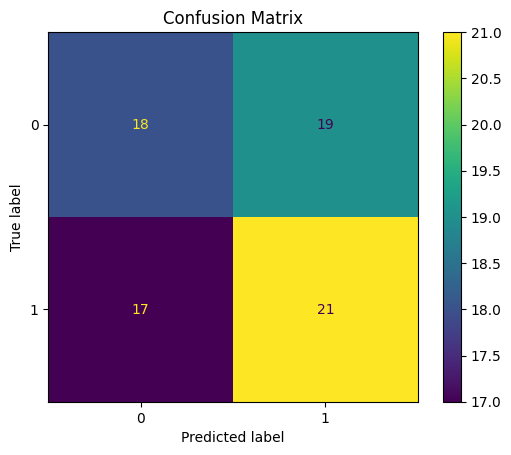

In [7]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title("Confusion Matrix")
plt.show()